<a href="https://colab.research.google.com/github/fxlmer/AJPom_cancer/blob/main/PrecisionRecall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import shutil

import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from AJPom_cancer_utils import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 2

LR = 1e-5 # Learning rate

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/AJPom_cancer_data

fatal: destination path 'AJPom_cancer_data' already exists and is not an empty directory.


In [5]:
train_path = '/content/AJPom_cancer_data/dataset/train' 
val_path = '/content/AJPom_cancer_data/dataset/val'
test_path = '/content/AJPom_cancer_data/dataset/test'

In [6]:
test_aug = ImageDataGenerator(rescale=1./255)

In [7]:
test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 160 images belonging to 2 classes.


In [8]:
!git clone https://github.com/fxlmer/AJPom_cancer

fatal: destination path 'AJPom_cancer' already exists and is not an empty directory.


In [9]:
test_model = tf.keras.models.load_model('/content/AJPom_cancer/AJPom_cancer_DenseNet121_model.h5')

In [10]:
num_test_files = len(test_generator.filenames)

In [11]:
test_generator.reset()

In [12]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [13]:
probs = predictions[:, 1]

In [14]:
y_pred = np.argmax(predictions, axis=1)

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [16]:
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
auc_keras = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)

In [17]:
roc_auc

0.99375

# Precision

In [18]:
precision, recall, thresholds = precision_recall_curve(test_labels, probs)

In [19]:
f1 = f1_score(test_labels, y_pred)

In [21]:
lr_precision, lr_recall, _ = precision_recall_curve(test_labels, probs)

In [22]:
lr_f1, lr_auc = f1_score(test_labels, y_pred), auc(lr_recall, lr_precision)

In [23]:
no_skill = len(test_labels[test_labels==1]) / len(test_labels)

In [24]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.994 auc=1.000


No handles with labels found to put in legend.


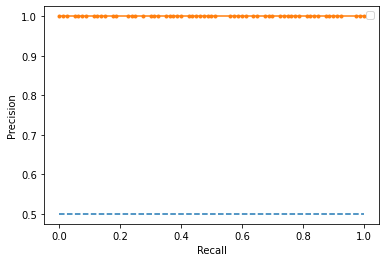

In [26]:
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()